In [2]:
#pip install transformers torch pandas


In [28]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [4]:
#load pretrained model:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

/home/youwei2/miniconda3/envs/ds/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
def calculate_surprisal(sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        logits = outputs.logits

    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    surprisal = -torch.sum(log_probs * torch.nn.functional.one_hot(input_ids, num_classes=logits.size(-1)).float())
    
    return surprisal.item()

In [8]:
df=pd.read_csv('ranking.csv')

In [10]:
df.columns

Index(['Example 1', 'Example 2', 'Example 3', 'Example 4', 'Example 5',
       'Rank for Example 1', 'Rank for Example 2', 'Rank for Example 3',
       'Rank for Example 4', 'Rank for Example 5', 'Ranker', 'Notes'],
      dtype='object')

In [11]:
columns=['Example 1', 'Example 2', 'Example 3', 'Example 4', 'Example 5']

for index,row in df.iterrows():
    for col in columns:
        sentence = row[col]
        surprisal = calculate_surprisal(sentence)
        df.at[index,col] = surprisal

In [13]:
df

,Example 1,Example 2,Example 3,Example 4,Example 5,Rank for Example 1,Rank for Example 2,Rank for Example 3,Rank for Example 4,Rank for Example 5,Ranker,Notes
0,152.246857,151.92981,169.330399,147.38353,184.840317,3.0,2.0,4.0,5.0,1.0,Ashwin,NaN
1,221.772766,232.925415,227.544739,227.256622,232.862091,3.0,5.0,4.0,5.0,1.0,Ashwin,NaN
2,421.786041,427.116669,416.434875,428.54303,438.784821,4.0,3.0,2.0,1.0,5.0,Ashwin,NaN
3,134.863129,135.380157,125.110168,133.241516,155.397812,3.0,4.0,5.0,2.0,1.0,Ashwin,NaN
4,141.780045,155.998108,144.978333,188.708496,159.58873,2.0,1.0,3.0,5.0,4.0,Ashwin,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
363,266.924011,265.751709,287.187927,345.617188,268.465851,2.0,1.0,3.0,5.0,4.0,Gabby,NaN
364,278.317505,293.69989,297.023865,277.166473,272.869568,3.0,3.0,3.0,3.0,3.0,Gabby,NaN
365,167.392532,171.038895,171.573868,187.641174,172.31897,3.0,1.0,2.0,4.0,5.0,Gabby,NaN
366,246.41333,249.866089,243.125214,263.617096,251.172729,5.0,5.0,5.0,5.0,5.0,Gabby,no sense


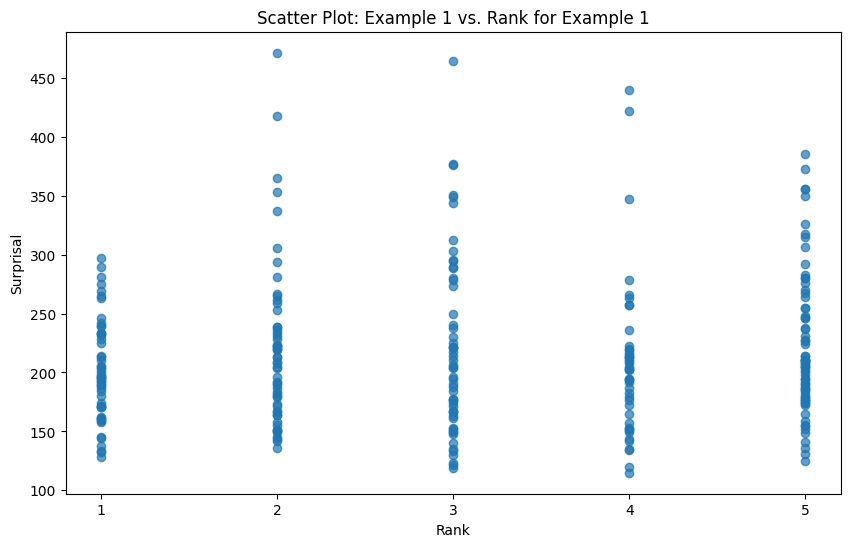

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter( df['Rank for Example 1'],df['Example 1'], alpha=0.7)
plt.title('Scatter Plot: Example 1 vs. Rank for Example 1')
plt.xlabel('Rank')
plt.ylabel('Surprisal')
plt.xticks(ticks=range(int(df['Rank for Example 1'].min()), int(df['Rank for Example 1'].max()) + 1))
plt.show()

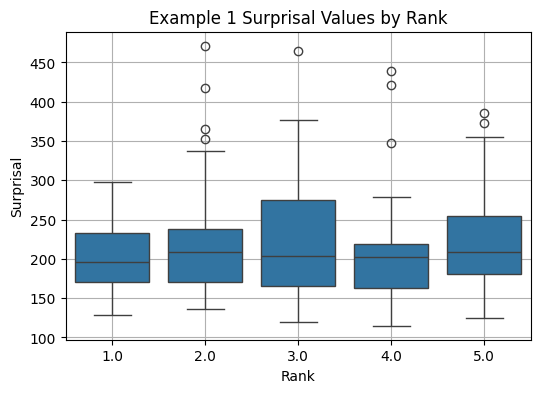

In [44]:
data = {'Surprisal': df['Example 1'],'Rank': df['Rank for Example 1']}

boxplot_data = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Rank', y='Surprisal', data=boxplot_data)
plt.title('Example 1 Surprisal Values by Rank')
plt.xlabel('Rank')
plt.ylabel('Surprisal')
plt.grid(True)
plt.show()

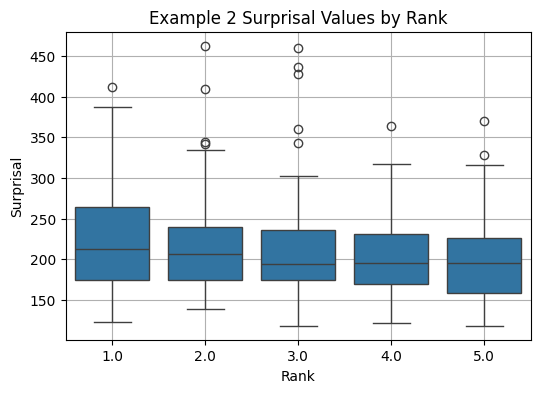

In [52]:
data = {'Surprisal': df['Example 2'],'Rank': df['Rank for Example 2']}

boxplot_data = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Rank', y='Surprisal', data=boxplot_data)
plt.title('Example 2 Surprisal Values by Rank')
plt.xlabel('Rank')
plt.ylabel('Surprisal')
plt.grid(True)
plt.show()

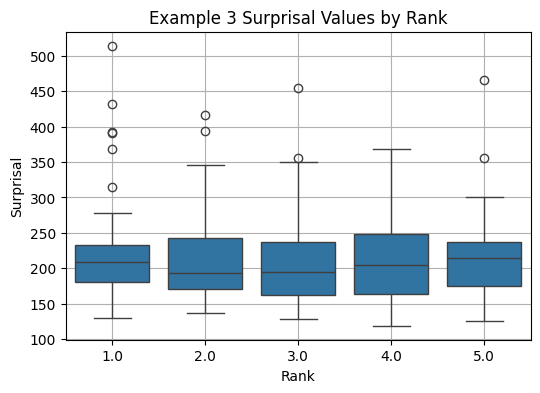

In [51]:
data = {'Surprisal': df['Example 3'],'Rank': df['Rank for Example 3']}

boxplot_data = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Rank', y='Surprisal', data=boxplot_data)
plt.title('Example 3 Surprisal Values by Rank')
plt.xlabel('Rank')
plt.ylabel('Surprisal')
plt.grid(True)
plt.show()

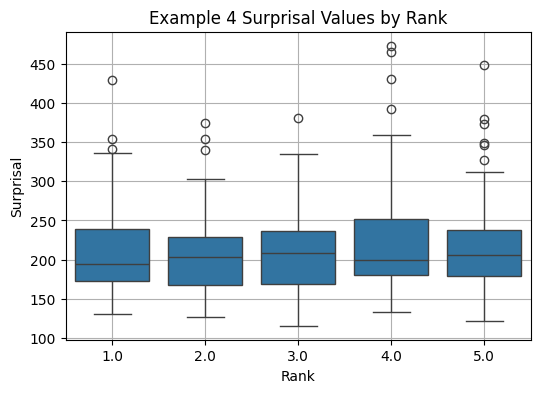

In [50]:
data = {'Surprisal': df['Example 4'],'Rank': df['Rank for Example 4']}

boxplot_data = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Rank', y='Surprisal', data=boxplot_data)
plt.title('Example 4 Surprisal Values by Rank')
plt.xlabel('Rank')
plt.ylabel('Surprisal')
plt.grid(True)
plt.show()

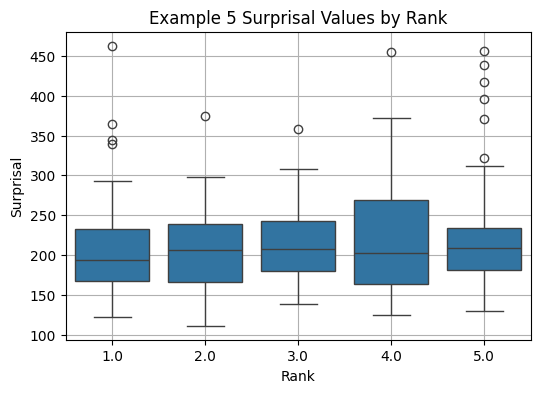

In [49]:
data = {'Surprisal': df['Example 5'],'Rank': df['Rank for Example 5']}

boxplot_data = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Rank', y='Surprisal', data=boxplot_data)
plt.title('Example 5 Surprisal Values by Rank')
plt.xlabel('Rank')
plt.ylabel('Surprisal')
plt.grid(True)
plt.show()